# Load Libs

In [23]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf
import seaborn as sns, keras
sns.set(style='white')

from collections import Counter, OrderedDict
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder, scale
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Activation, Input, Dropout, Embedding, Flatten, Input
from keras.layers import dot, add, Lambda, Concatenate, multiply, BatchNormalization
from keras.optimizers import Adam, SGD, Adagrad
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

np.set_printoptions(precision=4, suppress=True, linewidth=100)

# Data Preview

In [2]:
ratings = pd.read_csv('https://storage.googleapis.com/allianz-course/data/ratings.csv')
movies = pd.read_csv('https://storage.googleapis.com/allianz-course/data/movies.csv')

In [3]:
print(movies.shape)
movies.head()

(9125, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(ratings.shape)
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


# Encode

In [5]:
# Fit user id and movie id
uid_enc, mid_enc = LabelEncoder(), LabelEncoder()
uid_enc.fit(ratings.userId)
mid_enc.fit(movies.movieId)

# Encode user id and movie id to indexed real value
ratings["userId"] = uid_enc.transform(ratings.userId)
ratings["movieId"] = mid_enc.transform(ratings.movieId)
movies["movieId"] = mid_enc.transform(movies.movieId)

# Dictionary of movie id and title
mid_map = pd.Series(dict(zip(movies.movieId, movies.title)))

# Number of users, number of movies
n_users, n_movies = len(uid_enc.classes_), len(mid_enc.classes_)

# Split Train, Test Data
* 以4分為閥值, 4分以上為positive, 未滿4分為negative
* 每個user分positive, negative兩部分, 各取30%到valid data

In [6]:
def split_ratings(data, pos_thres=4, test_ratio=0.3):
    """依照test_ratio切割movielens train test資料"""
    tr, te = [], []
    for u, df in data.groupby("userId"):
        if len(df) < 5: continue

        pos, neg = df.query("rating >= {}".format(pos_thres)), df.query("rating < {}".format(pos_thres))
        # Split positive part
        pos_len = int(len(pos) * (1 - test_ratio))
        tr_pos = pos[:pos_len]
        te_pos = pos[pos_len:]
        # Split negative part
        neg_len = int(len(neg) * (1 - test_ratio))
        tr_neg = neg[:neg_len]
        te_neg = neg[neg_len:]

        tr.append(tr_pos.append(tr_neg))
        te.append(te_pos.append(te_neg))
    return pd.concat(tr, ignore_index=True), pd.concat(te, ignore_index=True)

tr, te = split_ratings(ratings, 4, .3)

# Make Rating Matrix (Interaction Between Users and Movies)

In [7]:
tr_rating_mat = np.zeros((n_users, n_movies))
# Valid data rating matrix
te_rating_mat = np.zeros((n_users, n_movies))

# Train rating matrix
for idx, r in tr.iterrows():
    tr_rating_mat[int(r.userId), int(r.movieId)] = r.rating
# Valid rating matrix    
for idx, r in te.iterrows():
    te_rating_mat[int(r.userId), int(r.movieId)] = r.rating
    
print('Shape of train interaction matrix: ', tr_rating_mat.shape)
print(tr_rating_mat, '\n')
print('Shape of test interaction matrix: ', te_rating_mat.shape)
print(te_rating_mat)

Shape of train interaction matrix:  (671, 9125)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]] 

Shape of test interaction matrix:  (671, 9125)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Encode Movies Table

In [8]:
def do_movies(movies):
    movies = movies.reset_index(drop=True)
    movies["genres"] = movies.genres.str.split("\|")
    genres_cnt = Counter()
    movies.genres.map(genres_cnt.update)
    genres_map = LabelEncoder()
    genres_map.fit( np.array(genres_cnt.most_common())[:, 0] )
    movies["genres"] = movies.genres.map(lambda lst: genres_map.transform(lst))
    
    movies["avg_rating"] = ratings.groupby("movieId").rating.mean()
    movies["avg_rating"] = scale(movies.avg_rating.fillna(movies.avg_rating.mean()))
    movies["freq_rating"] = ratings.groupby("movieId").size()
    movies["freq_rating"] = scale(movies.avg_rating.fillna(movies.freq_rating.median()))
    movies["year"] = movies.title.str.findall("\(\s*(\d+)\s*\)").map(lambda lst: int(lst[-1]) if len(lst) else None)
    movies["year"] = scale(movies.year.fillna(movies.year.mean()))

    return movies, genres_map

movies_encoded, genres_map = do_movies(movies)
n_genres = len(genres_map.classes_)
movies_encoded.head()

,movieId,title,genres,avg_rating,freq_rating,year
0,0,Toy Story (1995),"[2, 3, 4, 5, 9]",0.660265,0.660265,0.15651
1,1,Jumanji (1995),"[2, 4, 9]",0.124923,0.124923,0.15651
2,2,Grumpier Old Men (1995),"[5, 15]",-0.149065,-0.149065,0.15651
3,3,Waiting to Exhale (1995),"[5, 8, 15]",-1.032279,-1.032279,0.15651
4,4,Father of the Bride Part II (1995),[5],-0.027526,-0.027526,0.15651


# Encode Users Statistics

In [9]:
# user_encoded 
user_encoded = ratings.groupby('userId').rating.agg(['size', 'mean'])
user_encoded.columns = ['user_rating_freq', 'user_rating_mean']
user_encoded['user_rating_freq'] = scale(user_encoded.user_rating_freq)
user_encoded['user_rating_mean'] = scale(user_encoded.user_rating_mean)
user_encoded = user_encoded.reset_index()
user_encoded.head()

f:\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,userId,user_rating_freq,user_rating_mean
0,0,-0.558471,-2.351626
1,1,-0.316104,-0.362525
2,2,-0.424303,-0.188878
3,3,0.237878,1.465967
4,4,-0.212232,0.535923


# 以leave one out方式產生 train data, test data
1. 每一筆資料有兩部分: [user query] + [item id]
2. 每一筆user query 包含所有user movie history, 除了當前的rating movie (candidate movie)
3. test data的user query來自於train data

In [10]:
def loo_preprocess(data, movies_encoded, train_hist=None, is_train=True):
    """以leave one out方式產生 train data, test data"""
    queue = []
    data = data.merge(movies_encoded, how="left", on="movieId")
    data = data.merge(user_encoded, how="left", on="userId")
    columns = ["user_id", "query_movie_ids", "query_movie_ids_len", "user_rating_freq", "user_rating_mean",
               "genres", "genres_len", "avg_rating", "freq_rating", "year", "candidate_movie_id",
               "rating"]
    
    for u, df in data.groupby("userId"):
        df = df.sort_values("rating", ascending=False)
        # 抓出user給予正向評價的電影 (>= 4)
        if is_train:
            fav_movies = set(df.query("rating >= 4").movieId)
        else:
            fav_movies = set(train_hist.query(f"userId == {u} and rating >= 4").movieId)
        for i, (_, r) in enumerate(df.iterrows()):
            queries = list(fav_movies - set([int(r.movieId)]))
            # 對於multivalent的欄位, 需要增加一個column去描述該欄位的長度
            queue.append([int(r.userId),
                          queries,
                          len(queries),
                          r.user_rating_freq,
                          r.user_rating_mean,
                          r.genres,
                          len(r.genres),
                          r.avg_rating,
                          r.freq_rating,
                          r.year, 
                          int(r.movieId), 
                          r.rating])
    return pd.DataFrame(queue, columns=columns)

trProcessed = loo_preprocess(tr, movies_encoded)
teProcessed = loo_preprocess(te, movies_encoded, tr, is_train=False)
trProcessed.head()

,user_id,query_movie_ids,query_movie_ids_len,user_rating_freq,user_rating_mean,genres,genres_len,avg_rating,freq_rating,year,candidate_movie_id,rating
0,0,[1515],1,-0.558471,-2.351626,[8],1,1.102099,1.102099,-0.153507,931,4.0
1,0,[931],1,-0.558471,-2.351626,"[1, 6, 17]",3,0.830070,0.830070,-1.083561,1515,4.0
2,0,"[931, 1515]",2,-0.558471,-2.351626,"[9, 11, 15, 17]",4,0.006851,0.006851,0.001502,1083,3.5
3,0,"[931, 1515]",2,-0.558471,-2.351626,"[3, 4, 8, 13]",4,0.466777,0.466777,-2.633649,833,3.0
4,0,"[931, 1515]",2,-0.558471,-2.351626,[17],1,0.288261,0.288261,0.208180,859,3.0


In [11]:
teProcessed.head()

,user_id,query_movie_ids,query_movie_ids_len,user_rating_freq,user_rating_mean,genres,genres_len,avg_rating,freq_rating,year,candidate_movie_id,rating
0,0,"[931, 1515]",2,-0.558471,-2.351626,"[1, 2, 16]",3,0.212350,0.212350,-0.515195,1665,4.0
1,0,"[931, 1515]",2,-0.558471,-2.351626,"[2, 5]",2,0.252353,0.252353,-0.618534,1708,3.0
2,0,"[931, 1515]",2,-0.558471,-2.351626,"[5, 19]",2,0.731949,0.731949,-0.928552,2925,3.0
3,0,"[931, 1515]",2,-0.558471,-2.351626,"[8, 11, 16, 17]",4,0.115535,0.115535,-0.308516,1962,2.5
4,0,"[931, 1515]",2,-0.558471,-2.351626,"[1, 2, 9]",3,-0.102010,-0.102010,-0.205177,1743,2.0


## Data Function
1. 由於 Keras(Tensorflow backend) 不支援變動長度的columns, 需透過padding zero(補零)帶入
2. 每個變動長度的column, 需要再給lens描述每一筆資料的長度, ex: query_movie_ids, query_movie_ids_len

In [12]:
feats = ["query_movie_ids", "query_movie_ids_len", "user_rating_freq", "user_rating_mean",
         "genres", "genres_len", "avg_rating", "freq_rating", "year", "candidate_movie_id", 'global']
multi_cols = ["query_movie_ids", 'genres']
label = 'rating'

# Generator function
def dataFn(data, n_batch=128, shuffle=False):
    pad = pad_sequences
    def fn():
        while True:
            dataInner = data.copy()
            indices = get_minibatches_idx(len(dataInner), n_batch, shuffle=shuffle)
            for ind in indices:
                ret = do_multi(dataInner.iloc[ind], multi_cols)
                ret['global'] = 0
                yield [np.stack(ret[col].values) if col in multi_cols else ret[col][:, None]
                       for col in feats], ret.rating.values[:, None]
    return fn

def get_minibatches_idx(n, batch_size, shuffle=False):
    idx_list = np.arange(n, dtype="int32")
    if shuffle:
        np.random.shuffle(idx_list)
    minibatches = []
    minibatch_start = 0
    for i in range(n // batch_size):
        minibatches.append(idx_list[minibatch_start : minibatch_start + batch_size])
        minibatch_start += batch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])
    return minibatches

def do_multi(df, multi_cols):
    """Padding the multivalent feature"""
    pad = pad_sequences
    df = df.copy()
    for colname in multi_cols:
        lens = df[colname].map(len)
        df[colname] = list(pad(df[colname], padding="post", maxlen=lens.max()))
    return df

for data, label in dataFn(trProcessed, n_batch=5, shuffle=True)():
    break

for name, col in zip(feats, data):
    print(f'{name}\n{col}\n')
print(f'label\n{label}')

query_movie_ids
[[1024 2562 1794  262  520  521 2058  523  266  525 2062  527  528  529   15 1039  283  284   31
  1567 2592 1060 2340 2094   46  817  819 1590 1334 1336  826 2619  827 1853  829  832  321 2114
   833  835  834  837 2374 2375  328  836 2638 2643 2646  858 1631   96  866 2147 1379 1638 2150
  1640 1641 1131 2156  110 1647 1649 1393 1144  888  891 1921 1666 1922 2437  137 1422 1934  912
   399  147 1683 1685 1179 1695 1697 1699 2211  172 1199  953 2235  190  192 2241 1475  454  966
   969 1486  208  472  733 1247  225  483  740  741 2277 1253  232 1257 1509 2538 1516 2541  238
  1523 1269 2550  248 1022 1279    0    0    0    0    0    0    0    0    0    0    0]
 [   1  130  129    5  262  389  391  263  137   10  140  272  144  147   19   21   22  281  282
    26  284   30  163  294  303  180  183  184   57   58  315  314  321   66  198  199  328   73
   202  332  208  209   83  340  212   87  344  347  224   97  225  121  100  229  238  243  249
   252  253  254  383  

In [13]:
tmp = pd.DataFrame()
for col, val in zip(feats, data):
    if col in multi_cols:
        tmp[col] = list(val)
    else:
        tmp[col] = val.ravel()

tmp['rating'] = label.ravel()
tmp

,query_movie_ids,query_movie_ids_len,user_rating_freq,user_rating_mean,genres,genres_len,avg_rating,freq_rating,year,candidate_movie_id,global,rating
0,"[1024, 2562, 1794, 262, 520, 521, 2058, 523, 2...",120,1.233314,-0.789559,"[8, 15, 0, 0]",2,0.964746,0.964746,0.259850,1352,0,5.0
1,"[1, 130, 129, 5, 262, 389, 391, 263, 137, 10, ...",61,-0.099705,0.541652,"[5, 16, 0, 0]",2,-0.670797,-0.670797,0.104841,228,0,3.0
2,"[0, 1025, 513, 1024, 4, 2055, 520, 521, 10, 52...",131,0.558148,0.627725,"[5, 15, 0, 0]",2,0.016795,0.016795,0.156510,159,0,4.5
3,"[129, 225, 294, 262, 266, 140, 406, 0, 0, 0, 0...",7,-0.558471,-0.334588,"[6, 8, 0, 0]",2,1.359496,1.359496,0.104841,284,0,3.0
4,"[0, 1, 5, 519, 521, 523, 525, 15, 21, 22, 31, ...",130,0.666348,-0.036780,"[2, 3, 5, 6]",4,-0.295138,-0.295138,0.208180,1140,0,5.0


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

# Model of Matrix Factorization with DNN

## Build Model Function

In [24]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_u_freq = Input([1], dtype='float32', name='inp_u_freq')
    inp_u_mean = Input([1], dtype='float32', name='inp_u_mean')
    inp_genres = Input([None], dtype='int32', name='inp_genres')
    inp_genres_len = Input([1], dtype='int32', name='inp_genres_len')
    inp_avg_rating = Input([1], dtype='float32', name='inp_avg_rating')
    inp_freq_rating = Input([1], dtype='float32', name='inp_freq_rating')
    inp_year = Input([1], dtype='float32', name='inp_year')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_genres = Embedding(n_genres, 8, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_genres)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(tf.sequence_mask(lens, dtype=tf.float32), 1)
        weights = tf.expand_dims(weights, -1)
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    emb_query = Concatenate(1)([emb_query, inp_u_freq, inp_u_mean])
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_query)
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='user_impression')(emb_query)
    
    # Movie side
    emb_genres = Lambda(sqrtn, name='emb_genres')([emb_genres, inp_genres_len])
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    emb_movie = Concatenate(1)([emb_movie, emb_genres, inp_avg_rating, inp_freq_rating, inp_year])
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_movie)
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='movie_impression')(emb_movie)
    
    # Bias terms
    # Projection of emb_query to get bias
    b_user = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_user')(emb_query)
    # Projection of emb_movie to get bias
    b_movie = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_movie')(emb_movie)
    b_global = Flatten(name='b_global')(Embedding(1, 1, embeddings_initializer='glorot_uniform')(inp_global))
    
    # Implements the formulation
    nets = dot([emb_query, emb_movie], axes=1)
    nets = add([nets, b_user, b_movie, b_global])
    
    model = Model([inp_query, 
                   inp_query_len, 
                   inp_u_freq,
                   inp_u_mean,
                   inp_genres, 
                   inp_genres_len, 
                   inp_avg_rating,
                   inp_freq_rating,
                   inp_year,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model, Model([inp_movie, 
                         inp_genres, 
                         inp_genres_len, 
                         inp_avg_rating,
                         inp_freq_rating,
                         inp_year], emb_movie)

emb_size = 16
reg = 0.0005
batch_size = 128
epochs = 10

K.clear_session()
model_mf_dnn, model_emb_movie = get_model(n_users, n_movies, emb_size, reg)
model_mf_dnn.compile(optimizer=SGD(lr=0.05), loss='mse')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_query (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
inp_movie (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
inp_genres (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 16)     10736       inp_query[0][0]                  
__________________________________________________________________________________________________
inp_query_

# Training

## Use Callback Function
* keras.callbacks.ModelCheckpoint: 只存檔最好的結果, 是另一種防止overfitting的方式
    * save_best_only = True

Epoch 1/10
543/543 [==============================] - 10s 19ms/step - loss: 0.8734 - val_loss: 0.7322
Epoch 2/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7793 - val_loss: 0.7295
Epoch 3/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7718 - val_loss: 0.7765
Epoch 4/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7662 - val_loss: 0.7871
Epoch 5/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7592 - val_loss: 0.7192
Epoch 6/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7549 - val_loss: 0.7241
Epoch 7/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7528 - val_loss: 0.6997
Epoch 8/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7472 - val_loss: 0.8161
Epoch 9/10
543/543 [==============================] - 7s 12ms/step - loss: 0.7457 - val_loss: 0.6999
Epoch 10/10
543/543 [==============================] - 7s 12ms/step - loss: 0.7403 - val_l

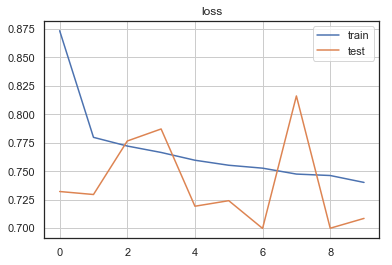

In [25]:
model_dir = "./model_mf_dnn"

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction

In [26]:
te_len = len(teProcessed)
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()
print('Shape of test data: ', pred.shape)

Shape of test data:  (30605,)


# Metrics
* 定義4分以上為正向評價, 4分以下為負向評價

## RMSE 

In [27]:
te_len = len(teProcessed)
valis_steps = te_len // batch_size + (1 if te_len % batch_size else 0)

te_y = []
for i, (feat, label) in enumerate(dataFn(teProcessed, 
                                         n_batch=batch_size, 
                                         shuffle=False)(), 1):
    if i > valis_steps: break
    te_y += label.ravel().tolist()
    
te_y = np.array(te_y)
print("RMSE: ", np.sqrt(np.mean((pred - te_y)**2)))

RMSE:  0.8045415779932191


## AUC

auc: 0.8129714239285255


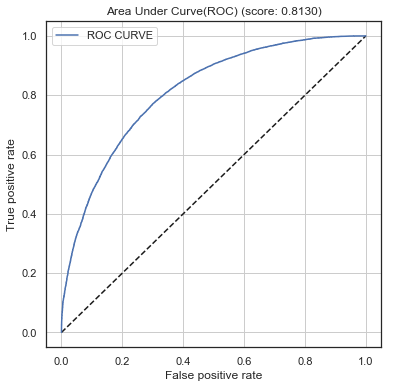

In [28]:
def draw_roc_curve(y, pred_proba):
    fpr, tpr, _ = roc_curve(y, pred_proba, pos_label=1)
    auc_scr = auc(fpr, tpr)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.grid(True)
    plt.show()
    
draw_roc_curve(te.rating >= 4, pred / pred.max())

## Single User Rating Histogram

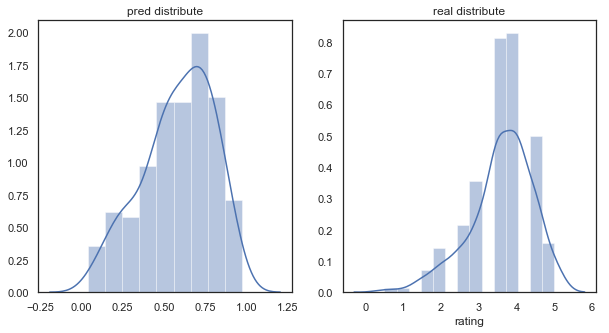

In [65]:
# user id from 0 ~ 670
uid = 22
tmp = teProcessed.query(f"user_id == {uid}")
single_pred = model_mf_dnn.predict_generator(
    generator=dataFn(tmp, n_batch=batch_size, shuffle=False)(),
    steps=len(tmp) // batch_size + (1 if len(tmp) % batch_size else 0)
).ravel()

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribute")
sns.distplot(single_pred, ax=ax[0])
ax[1].set_title("real distribute")
sns.distplot(te.query(f"userId == '{uid}'").rating, ax=ax[1])
plt.show()

## Single User Detail Table

In [33]:
# user id from 0 ~ 670
uid = 22
tmp = teProcessed.query(f"user_id == {uid}")
single_pred = model_mf_dnn.predict_generator(
    generator=dataFn(tmp, n_batch=batch_size, shuffle=False)(),
    steps=len(tmp) // batch_size + (1 if len(tmp) % batch_size else 0)
).ravel()

recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": tmp.candidate_movie_id,
              "title": mid_map[tmp.candidate_movie_id].values,
              "rating": tmp.rating.values,
              "predRating": single_pred},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.sort_values("rating", ascending=False)

,userId,movieId,title,rating,predRating
1224,22,4855,Kill Bill: Vol. 1 (2003),5.0,3.903784
1230,22,5016,Stolen Kisses (Baisers volés) (1968),5.0,4.412870
1225,22,6132,Crash (2004),5.0,4.098488
1234,22,4371,Adaptation (2002),5.0,3.917500
1232,22,4008,And Your Mother Too (Y tu mamá también) (2001),5.0,4.064291
1231,22,4432,City of God (Cidade de Deus) (2002),5.0,4.358509
1233,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,5.236749
1229,22,5761,Duel (1971),5.0,4.182854
1228,22,4419,"Hours, The (2002)",5.0,3.939949
1227,22,4417,Catch Me If You Can (2002),5.0,4.076881


In [34]:
recommDf.sort_values("predRating", ascending=False)

,userId,movieId,title,rating,predRating
1233,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,5.236749
1226,22,5623,Undertow (2004),5.0,5.144791
1283,22,4751,Ikiru (1952),4.0,4.972904
1296,22,3957,"Bad and the Beautiful, The (1952)",4.0,4.811474
1269,22,4724,Umberto D. (1952),4.5,4.698143
1331,22,5369,Viridiana (1961),3.5,4.682635
1316,22,5227,Zorba the Greek (Alexis Zorbas) (1964),4.0,4.675735
1281,22,6185,Last Days (2005),4.0,4.593620
1268,22,4241,Heaven (2002),4.5,4.578270
1322,22,5333,Sunrise: A Song of Two Humans (1927),4.0,4.558904


<br/>
<br/>
<br/>

# 利用 Movie Embedding 找出相似電影

In [93]:
movies[movies.title.str.contains("Toy")]

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1579,1579,Babes in Toyland (1961),Children|Fantasy|Musical
1780,1780,Toys (1992),Comedy|Fantasy
2479,2479,Babes in Toyland (1934),Children|Comedy|Fantasy|Musical
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3829,3829,"Toy, The (1982)",Comedy
4341,4341,Toy Soldiers (1991),Action|Drama
7556,7556,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
8437,8437,Toy Story of Terror (2013),Animation|Children|Comedy


In [76]:
model_mf_dnn.load_weights(model_dir)

# Movie data function generator
movies_cols = ['movieId', 'genres', 'genres_len', 'avg_rating', 'freq_rating', 'year']
def movie_data_fn(data, batch_size=128):
    def _fn():
        data_inner = data.copy()
        while True:
            indices = get_minibatches_idx(len(data_inner), batch_size, shuffle=False)
            for ind in indices:
                ret = do_multi(data_inner.iloc[ind], ['genres'])
                ret['global'] = 0
                yield [np.stack(ret[col].values) if col in ['genres'] else ret[col][:, None]
                       for col in movies_cols]
    return _fn

def most_like(model, seed_movie, k=10):
    """給定某一部電影, 使用model裡movies embedding找尋cosine相似度高的其他電影!"""
    tmp = movies_encoded.copy()
    tmp['genres_len'] = tmp.genres.map(len)
    movie_emb = model.predict_generator(
        generator=movie_data_fn(tmp, batch_size)(),
        steps=len(tmp) // batch_size + (1 if len(tmp) % batch_size else 0)
    )
    # print(cosine_similarity(movie_emb[seed_movie][np.newaxis, :], movie_emb))
    most_like = cosine_similarity(movie_emb[seed_movie][np.newaxis, :], movie_emb).ravel().argsort()[::-1][:k]
    return movies.iloc[most_like]

# mse訓練出來的model
most_like(model_emb_movie, 7575, k=11)

[[0.8883 0.5633 0.4862 ... 0.8764 0.554  0.499 ]]


,movieId,title,genres
7575,7575,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
6383,6383,V for Vendetta (2006),Action|Sci-Fi|Thriller|IMAX
8460,8460,Frozen (2013),Adventure|Animation|Comedy|Fantasy|Musical|Rom...
8514,8514,Wonder Woman (2009),Action|Adventure|Animation|Fantasy
7220,7220,Red Cliff Part II (Chi Bi Xia: Jue Zhan Tian X...,Action|Drama|War
8393,8393,In a World... (2013),Comedy
8608,8608,How to Train Your Dragon 2 (2014),Action|Adventure|Animation
8966,8966,The Intern (2015),Comedy
8477,8477,Oldboy (2013),Action|Drama|Mystery
9061,9061,Sherlock: The Abominable Bride (2016),Action|Crime|Drama|Mystery|Thriller


<br/>
<br/>
<br/>

# (LAB) 將Model從Regression改為Classification

## Modify Data Generator

In [14]:
# Generator function
def dataFn(data, n_batch=128, shuffle=False):
    pad = pad_sequences
    def fn():
        while True:
            dataInner = data.copy()
            indices = get_minibatches_idx(len(dataInner), n_batch, shuffle=shuffle)
            for ind in indices:
                ret = do_multi(dataInner.iloc[ind], multi_cols)
                ret['global'] = 0
                yield [np.stack(ret[col].values) if col in multi_cols else ret[col][:, None]
                       for col in feats], (ret.rating >= 4).astype(int)[:, None]
    return fn

for data, label in dataFn(trProcessed, n_batch=5, shuffle=False)():
    break

print(f'label\n{label}')

label
[[1]
 [1]
 [0]
 [0]
 [0]]


In [ ]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_u_freq = Input([1], dtype='float32', name='inp_u_freq')
    inp_u_mean = Input([1], dtype='float32', name='inp_u_mean')
    inp_genres = Input([None], dtype='int32', name='inp_genres')
    inp_genres_len = Input([1], dtype='int32', name='inp_genres_len')
    inp_avg_rating = Input([1], dtype='float32', name='inp_avg_rating')
    inp_freq_rating = Input([1], dtype='float32', name='inp_freq_rating')
    inp_year = Input([1], dtype='float32', name='inp_year')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_genres = Embedding(n_genres, 8, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_genres)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(tf.sequence_mask(lens, dtype=tf.float32), 1)
        weights = tf.expand_dims(weights, -1)
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    emb_query = Concatenate(1)([emb_query, inp_u_freq, inp_u_mean])
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_query)
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='user_impression')(emb_query)
    
    # Movie side
    emb_genres = Lambda(sqrtn, name='emb_genres')([emb_genres, inp_genres_len])
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    emb_movie = Concatenate(1)([emb_movie, emb_genres, inp_avg_rating, inp_freq_rating, inp_year])
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_movie)
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='movie_impression')(emb_movie)
    
    # Bias terms
    # Projection of emb_query to get bias
    b_user = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_user')(emb_query)
    # Projection of emb_movie to get bias
    b_movie = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_movie')(emb_movie)
    b_global = Flatten(name='b_global')(Embedding(1, 1, embeddings_initializer='glorot_uniform')(inp_global))
    
    # Implements the formulation
    nets = dot([emb_query, emb_movie], axes=1)
    nets = add([nets, b_user, b_movie, b_global])
    
    ###### START CODE HERE ######
    # Modify the model prediction to 0 ~ 1, hint: add an activation function
    # ...
    ###### END CODE HERE ######
    
    model = Model([inp_query, 
                   inp_query_len, 
                   inp_u_freq,
                   inp_u_mean,
                   inp_genres, 
                   inp_genres_len, 
                   inp_avg_rating,
                   inp_freq_rating,
                   inp_year,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model, Model([inp_movie, 
                         inp_genres, 
                         inp_genres_len, 
                         inp_avg_rating,
                         inp_freq_rating,
                         inp_year], emb_movie)

###### START CODE HERE ######
# Modify the hyper parameters to get even better result
emb_size = # 8, 10, 16 ...
reg = # 0.01, 0.005, 0.0005 ...
batch_size = 128
epochs =  # 10, 20 , 30 ...
lr = # 0.1, 0.05, 0.001
###### END CODE HERE ######

model_dir = "./model_mf_dnn"
K.clear_session()
model_mf_dnn, model_emb_movie = get_model(n_users, n_movies, emb_size, reg)

###### START CODE HERE ######
# Find best optimizer, e.g: Adam, SGD, Adagrad, find proper loss function
# model_mf_dnn.compile(...)
###### END CODE HERE ######

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()


te_labels = (teProcessed.rating >= 4).astype(int)

# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_labels, pred)

# Confusion matrix, classification report
from sklearn.metrics import confusion_matrix, classification_report
print('accuracy_score: ', accuracy_score(te_labels, pred >= 0.5))
print(confusion_matrix(te_labels, pred >= 0.5))
print()
print(classification_report(te_labels, pred >= 0.5))

most_like(model_emb_movie, 8787, k=11)

## 利用Movie Embedding, 以Cosine Similarity找出前10名相似電影

In [69]:
movies[movies.title.str.contains("Inception")]

,movieId,title,genres
7575,7575,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX


In [ ]:
# Call most_like function 找出前10名相似電影
# most_like(...)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Solution

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_query (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
inp_movie (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
inp_genres (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 16)     10736       inp_query[0][0]                  
__________________________________________________________________________________________________
inp_query_

Epoch 7/10
543/543 [==============================] - 7s 13ms/step - loss: 0.5796 - val_loss: 0.5762
Epoch 8/10
543/543 [==============================] - 7s 13ms/step - loss: 0.5762 - val_loss: 0.5740
Epoch 9/10
543/543 [==============================] - 7s 13ms/step - loss: 0.5734 - val_loss: 0.5689
Epoch 10/10
543/543 [==============================] - 7s 13ms/step - loss: 0.5707 - val_loss: 0.5667


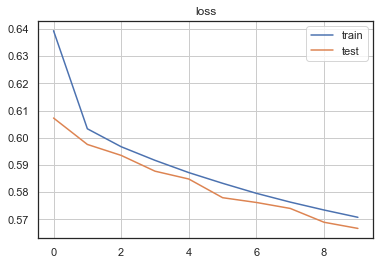

Shape of test data:  (30605,)
auc: 0.8168108171662702


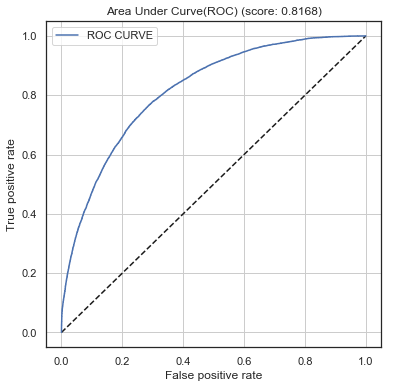

accuracy_score:  <function accuracy_score at 0x000001B72FE59A60>
[[10516  4313]
 [ 3637 12139]]

             precision    recall  f1-score   support

          0       0.74      0.71      0.73     14829
          1       0.74      0.77      0.75     15776

avg / total       0.74      0.74      0.74     30605

[[1.     0.9745 0.9337 ... 0.9927 0.8563 0.9741]]


,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3805,3805,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
918,918,Lesson Faust (1994),Animation|Comedy|Drama|Fantasy
2289,2289,Stop Making Sense (1984),Documentary|Musical
8528,8528,No Nukes (1980),Documentary|Musical
971,971,Army of Darkness (1993),Action|Adventure|Comedy|Fantasy|Horror
6100,6100,Harvie Krumpet (2003),Animation|Comedy|Drama
12,12,Balto (1995),Adventure|Animation|Children
8108,8108,Dragon Ball Z: The History of Trunks (Doragon ...,Action|Adventure|Animation


In [28]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_u_freq = Input([1], dtype='float32', name='inp_u_freq')
    inp_u_mean = Input([1], dtype='float32', name='inp_u_mean')
    inp_genres = Input([None], dtype='int32', name='inp_genres')
    inp_genres_len = Input([1], dtype='int32', name='inp_genres_len')
    inp_avg_rating = Input([1], dtype='float32', name='inp_avg_rating')
    inp_freq_rating = Input([1], dtype='float32', name='inp_freq_rating')
    inp_year = Input([1], dtype='float32', name='inp_year')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_genres = Embedding(n_genres, 8, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_genres)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(tf.sequence_mask(lens, dtype=tf.float32), 1)
        weights = tf.expand_dims(weights, -1)
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    emb_query = Concatenate(1)([emb_query, inp_u_freq, inp_u_mean])
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_query)
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='user_impression')(emb_query)
    
    # Movie side
    emb_genres = Lambda(sqrtn, name='emb_genres')([emb_genres, inp_genres_len])
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    emb_movie = Concatenate(1)([emb_movie, emb_genres, inp_avg_rating, inp_freq_rating, inp_year])
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_movie)
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='movie_impression')(emb_movie)
    
    # Bias terms
    # Projection of emb_query to get bias
    b_user = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_user')(emb_query)
    # Projection of emb_movie to get bias
    b_movie = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_movie')(emb_movie)
    b_global = Flatten(name='b_global')(Embedding(1, 1, embeddings_initializer='glorot_uniform')(inp_global))
    
    # Implements the formulation
    nets = dot([emb_query, emb_movie], axes=1)
    nets = add([nets, b_user, b_movie, b_global])
    
    ###### START CODE HERE ######
    # Modify the model prediction to 0 ~ 1, hint: add an activation function
    nets = Activation("sigmoid")(nets)
    ###### END CODE HERE ######
    
    model = Model([inp_query, 
                   inp_query_len, 
                   inp_u_freq,
                   inp_u_mean,
                   inp_genres, 
                   inp_genres_len, 
                   inp_avg_rating,
                   inp_freq_rating,
                   inp_year,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model, Model([inp_movie, 
                         inp_genres, 
                         inp_genres_len, 
                         inp_avg_rating,
                         inp_freq_rating,
                         inp_year], emb_movie)

###### START CODE HERE ######
# Modify the hyper parameters to get even better result
emb_size = 16
reg = 0.0005
batch_size = 128
epochs = 10
lr = 0.05
###### END CODE HERE ######

model_dir = "./model_mf_dnn"
K.clear_session()
model_mf_dnn, model_emb_movie = get_model(n_users, n_movies, emb_size, reg)

model_mf_dnn.compile(optimizer=SGD(lr=lr), loss='binary_crossentropy')

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()

te_labels = (teProcessed.rating >= 4).astype(int)
# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_labels, pred)

# Confusion matrix, classification report
print('accuracy_score: ', accuracy_score(te_labels, pred >= 0.5))
print(confusion_matrix(te_labels, pred >= 0.5))
print()
print(classification_report(te_labels, pred >= 0.5))

most_like(model_emb_movie, 0, k=11)

<br/>
<br/>
<br/>

# (LAB) 延續Classification, 以DNN作法取代MF作法

* Concatenate [user, movie], 且用 dense layer 增加hidden layers

In [ ]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_u_freq = Input([1], dtype='float32', name='inp_u_freq')
    inp_u_mean = Input([1], dtype='float32', name='inp_u_mean')
    inp_genres = Input([None], dtype='int32', name='inp_genres')
    inp_genres_len = Input([1], dtype='int32', name='inp_genres_len')
    inp_avg_rating = Input([1], dtype='float32', name='inp_avg_rating')
    inp_freq_rating = Input([1], dtype='float32', name='inp_freq_rating')
    inp_year = Input([1], dtype='float32', name='inp_year')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_genres = Embedding(n_genres, 8, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_genres)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(tf.sequence_mask(lens, dtype=tf.float32), 1)
        weights = tf.expand_dims(weights, -1)
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    emb_query = Concatenate(1)([emb_query, inp_u_freq, inp_u_mean])
    emb_query = Dense(emb_size, activation='relu')(emb_query)
    emb_query = Dense(emb_size, activation='relu', name='user_impression')(emb_query)
    
    # Movie side
    emb_genres = Lambda(sqrtn, name='emb_genres')([emb_genres, inp_genres_len])
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    emb_movie = Concatenate(1)([emb_movie, emb_genres, inp_avg_rating, inp_freq_rating, inp_year])
    emb_movie = Dense(emb_size, activation='relu')(emb_movie)
    emb_movie = Dense(emb_size, activation='relu', name='movie_impression')(emb_movie)
    
    ###### START CODE HERE ######
    # Concatenate the user and movie embedding, add 2 hidden layers
    # Maybe you need Dropout! BatchNormalization, etc..., try it for the better result!
    # nets = Concatenate(1)([emb_query, emb_movie])
    # nets = Dense(...)(nets)
    # ...
    ###### END CODE HERE ######
    
    model = Model([inp_query, 
                   inp_query_len, 
                   inp_u_freq,
                   inp_u_mean,
                   inp_genres, 
                   inp_genres_len, 
                   inp_avg_rating,
                   inp_freq_rating,
                   inp_year,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model, Model([inp_movie, 
                         inp_genres, 
                         inp_genres_len, 
                         inp_avg_rating,
                         inp_freq_rating,
                         inp_year], emb_movie)

###### START CODE HERE ######
# Modify the hyper parameters to get even better result
emb_size = # 8, 10, 16 ...
reg = # 0.01, 0.005, 0.0005 ...
batch_size = 128
epochs =  # 10, 20 , 30 ...
lr = # 0.1, 0.05, 0.001
###### END CODE HERE ######

model_dir = "./model_mf_dnn"
K.clear_session()
model_mf_dnn, model_emb_movie = get_model(n_users, n_movies, emb_size, reg)

###### START CODE HERE ######
# Find best optimizer, e.g: Adam, SGD, Adagrad, find proper loss function
# model_mf.compile(...)
###### END CODE HERE ######

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
te_len = len(teProcessed)
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()


te_labels = (teProcessed.rating >= 4).astype(int)
# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_labels, pred)

# Confusion matrix, classification report
print('accuracy_score: ', accuracy_score(te_labels, pred >= 0.5))
print(confusion_matrix(te_labels, pred >= 0.5))
print()
print(classification_report(te_labels, pred >= 0.5))

most_like(model_emb_movie, 8787, k=11)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Solution

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_query (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
inp_movie (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
inp_genres (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 16)     10736       inp_query[0][0]                  
__________________________________________________________________________________________________
inp_query_

Epoch 10/10
543/543 [==============================] - 8s 15ms/step - loss: 0.5411 - val_loss: 0.5619


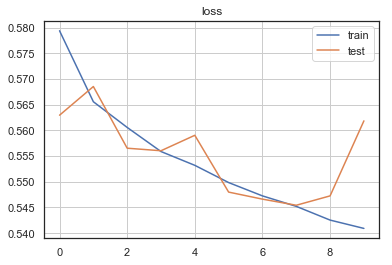

Shape of test data:  (30605,)
auc: 0.8171021902904744


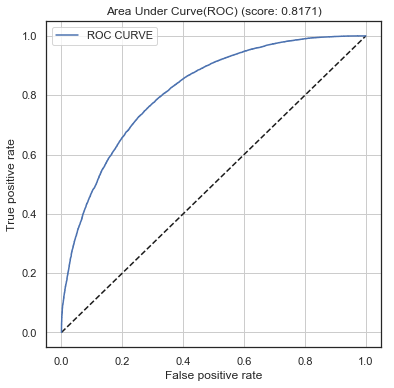

accuracy_score:  <function accuracy_score at 0x000001B72FE59A60>
[[10378  4451]
 [ 3577 12199]]

             precision    recall  f1-score   support

          0       0.74      0.70      0.72     14829
          1       0.73      0.77      0.75     15776

avg / total       0.74      0.74      0.74     30605

[[1.     0.9687 0.9398 ... 0.9704 0.3804 0.97  ]]


,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2531,2531,"Green Mile, The (1999)",Crime|Drama
940,940,"Shooter, The (1997)",Western
3023,3023,Croupier (1998),Crime|Drama
4365,4365,Brother (Brat) (1997),Crime|Drama
5878,5878,Whisper of the Heart (Mimi wo sumaseba) (1995),Animation|Drama|Romance
1843,1843,American History X (1998),Crime|Drama
7533,7533,12 Angry Men (1997),Crime|Drama
3153,3153,Digimon: The Movie (2000),Adventure|Animation|Children
240,240,Little Odessa (1994),Crime|Drama


In [29]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_u_freq = Input([1], dtype='float32', name='inp_u_freq')
    inp_u_mean = Input([1], dtype='float32', name='inp_u_mean')
    inp_genres = Input([None], dtype='int32', name='inp_genres')
    inp_genres_len = Input([1], dtype='int32', name='inp_genres_len')
    inp_avg_rating = Input([1], dtype='float32', name='inp_avg_rating')
    inp_freq_rating = Input([1], dtype='float32', name='inp_freq_rating')
    inp_year = Input([1], dtype='float32', name='inp_year')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_genres = Embedding(n_genres, 8, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_genres)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(tf.sequence_mask(lens, dtype=tf.float32), 1)
        weights = tf.expand_dims(weights, -1)
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    emb_query = Concatenate(1)([emb_query, inp_u_freq, inp_u_mean])
    emb_query = Dense(emb_size, activation='relu')(emb_query)
    emb_query = Dense(emb_size, activation='relu', name='user_impression')(emb_query)
    
    # Movie side
    emb_genres = Lambda(sqrtn, name='emb_genres')([emb_genres, inp_genres_len])
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    emb_movie = Concatenate(1)([emb_movie, emb_genres, inp_avg_rating, inp_freq_rating, inp_year])
    emb_movie = Dense(emb_size, activation='relu')(emb_movie)
    emb_movie = Dense(emb_size, activation='relu', name='movie_impression')(emb_movie)
    
    ###### START CODE HERE ######
    # Concatenate the user and movie embedding, add 2 hidden layers
    # Maybe you need Dropout! BatchNormalization, etc..., try it for the better result!
    nets = Concatenate(1)([emb_query, emb_movie])
    nets = Dense(32, activation='linear')(nets)
    nets = Activation('relu')(BatchNormalization()(nets))
    nets = Dense(16, activation='linear')(nets)
    nets = Activation('relu')(BatchNormalization()(nets))
    nets = Dense(1, activation='sigmoid')(nets)
    ###### END CODE HERE ######
    
    model = Model([inp_query, 
                   inp_query_len, 
                   inp_u_freq,
                   inp_u_mean,
                   inp_genres, 
                   inp_genres_len, 
                   inp_avg_rating,
                   inp_freq_rating,
                   inp_year,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model, Model([inp_movie, 
                         inp_genres, 
                         inp_genres_len, 
                         inp_avg_rating,
                         inp_freq_rating,
                         inp_year], emb_movie)

###### START CODE HERE ######
# Modify the hyper parameters to get even better result
emb_size = 16
reg = 0.0005
batch_size = 128
epochs = 10
lr = 0.05
###### END CODE HERE ######

model_dir = "./model_mf_dnn"
K.clear_session()
model_mf_dnn, model_emb_movie = get_model(n_users, n_movies, emb_size, reg)

model_mf_dnn.compile(optimizer=SGD(lr=lr), loss='binary_crossentropy')

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
te_len = len(teProcessed)
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()


te_labels = (teProcessed.rating >= 4).astype(int)
# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_labels, pred)

# Confusion matrix, classification report
print('accuracy_score: ', accuracy_score(te_labels, pred >= 0.5))
print(confusion_matrix(te_labels, pred >= 0.5))
print()
print(classification_report(te_labels, pred >= 0.5))

most_like(model_emb_movie, 0, k=11)